In [1]:
import torch
from transformers import AutoTokenizer
from data_utils import NewsDataset

from torch.utils.data import DataLoader

import argparse

from model import Transformer, CustomBertForClassification

from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

/home/valeriy/python_envs/news_category_classification/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from inference import predict, load_model, load_tokenizer, index_to_category

In [5]:
train_batch_size=32
eval_batch_size = 100
accumulation_steps = 150

train_test_split = [0.8, 0.2]
val_test_split = [0.5, 0.5]
epochs = 100
device='cuda'

model_path='../weights_final_81_acc.pt'

In [ ]:
if device == 'cuda':
    assert torch.cuda.is_available()

tokenizer = load_tokenizer()
model = load_model(model_path, tokenizer).to(device)


from torch.utils.data import DataLoader
ds = NewsDataset('data.json')

generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(ds, train_test_split,generator=generator)
val_data, test_data = torch.utils.data.random_split(test_data, val_test_split,generator=generator)

dataloader = DataLoader(test_data, batch_size=eval_batch_size,
                        shuffle=False, num_workers=0)


preds = predict(model, tokenizer, dataloader, device)#15m

categorical_preds  = [index_to_category[idx] for idx in preds]
print(categorical_preds)

In [21]:
import numpy as np
labels = []
for v in dataloader:
    labels.append(v['y'])

labels = np.concatenate(labels)
labels = [index_to_category[idx] for idx in labels]

In [7]:
from sklearn.metrics import confusion_matrix

In [8]:

cm_original = confusion_matrix(labels, categorical_preds)

In [2]:
cm_original

NameError: name 'cm_original' is not defined

In [9]:

cm_norm = confusion_matrix(labels, categorical_preds, normalize='true')

<Axes: >

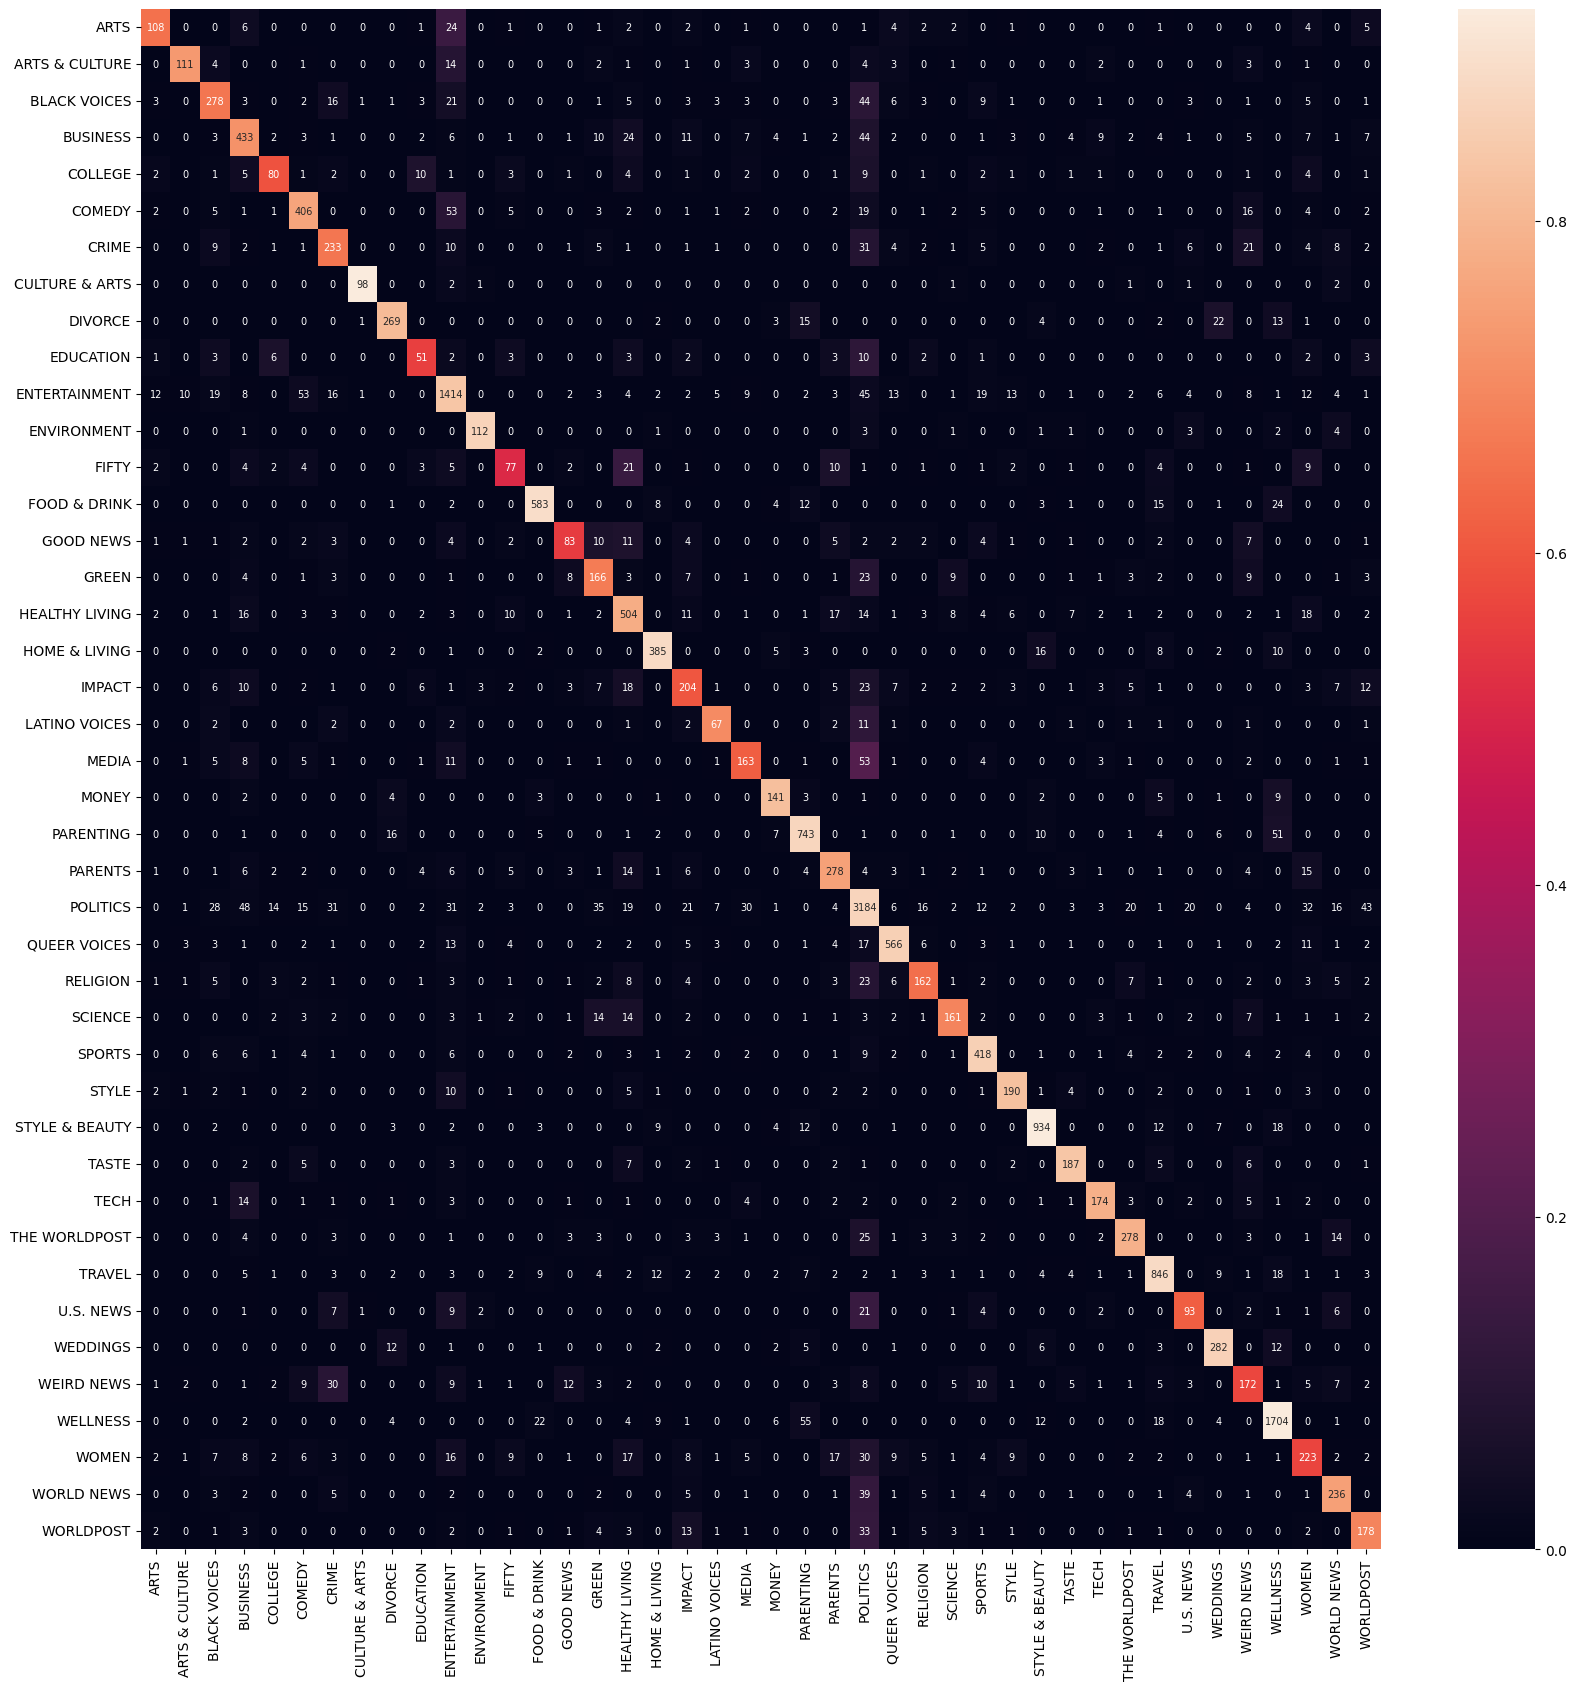

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm_norm,
            ax=ax,
            annot=cm_original,
            fmt='d',
            annot_kws={"size": 7},
            xticklabels=np.unique(np.array(labels)),
            yticklabels=np.unique(np.array(labels)))

In [11]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

In [12]:
print('f1', f1_score(labels, categorical_preds, average='macro'))
print('recall_score', recall_score(labels, categorical_preds, average='macro'))
print('precision_score', precision_score(labels, categorical_preds, average='macro'))
#print('roc_auc_score', roc_auc_score(labels, categorical_preds, average='macro'))

f1 0.7538438245430458
recall_score 0.7471816125380796
precision_score 0.7621414447651548


In [31]:


f1_scores = f1_score(labels, categorical_preds, average=None)
precision_scores = precision_score(labels, categorical_preds, average=None)
recall_scores = recall_score(labels, categorical_preds, average=None)



In [32]:
df = pd.DataFrame({'f1':f1_scores,'precision':precision_scores, 'recall':recall_scores})

In [34]:

df['category'] = [index_to_category[idx] for idx in range(len(df))]

In [37]:
df.sort_values(by='f1', ascending=False)

,f1,precision,recall,category
7,0.942308,0.960784,0.924528,CULTURE & ARTS
30,0.933067,0.938693,0.927507,STYLE & BEAUTY
38,0.917609,0.910256,0.925081,WELLNESS
13,0.909516,0.928344,0.891437,FOOD & DRINK
11,0.892430,0.918033,0.868217,ENVIRONMENT
17,0.885057,0.883028,0.887097,HOME & LIVING
34,0.883551,0.881250,0.885864,TRAVEL
25,0.869432,0.878882,0.860182,QUEER VOICES
22,0.866472,0.857968,0.875147,PARENTING
24,0.860773,0.850882,0.870897,POLITICS


## Conclusions About Confusions

### Most Common Confusions:

| **Label**         | **Prediction**               |
|--------------------|------------------------------|
| Fifty             | Health and Living, Parents  |
| Media             | Politics                    |

### Key Observations:

1. **Politics Confusions**  
   - Politics is the category with the highest number of confusions.  
   - However, it is also the most frequently occurring category, which could explain the increased rate of misclassifications.

2. **Entertainment Confusions**  
   - Entertainment is often confused with Arts and Comedy.  
   - This indicates a potential overlap in themes or classification criteria among these categories.
